## _Reinforcment Learning_
### _Dynamic Programing Exercise_   

In [1]:
import numpy as np
import random
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import copy
import matplotlib.pyplot as plt

In [2]:
class World:
    def __init__(self, gridSize = (4, 4), terminalPositions = [(0,0), (3,3)]):
        self.gridSize = gridSize
        self.terminalPos1 = terminalPositions[0]
        self.terminalPos2 = terminalPositions[1]
        self.world = self.environment()

    def environment(self): 
        """
        Generates a grid world of size gridSize + 1, where -1's indicate walls/obstacles.
        """
        gridWorld = np.zeros((self.gridSize[0]+2,self.gridSize[1]+2), dtype = np.int16)

        # External Walls
        gridWorld[0,:] = -1
        gridWorld[self.gridSize[0]+1,:] = -1
        gridWorld[:,0] = -1
        gridWorld[:,self.gridSize[1]+1] = -1

        return gridWorld
    
    def rewardFunction(self):
        """
        Each time the agent makes a move is recieves a reward of -1.
        """
        TransitionReward = -1
        return TransitionReward
    
    def showMatrix(self, mat):
        x,y = np.shape(mat)
        for i in range(x):
            print(mat[i])
        print("")

    def transitionFunction(self, state, action):
        """
        The dynamics of the agents movement is defined here.
        After the agent chooses an action, the environment decides how that action changes the environments configuration.
        Given the agents action, the output is the agents new state in the environment after that action has been taken.
        Returns the new state.
        Note: The Agent stays in palce if it moves into a wall or obstacle.
        """
        
        # Offset to align grid world and value function.
        # Required beacuse of environment walls
        newState = [state[0]+1, state[1]+1]

        # Determine agents new state in the environment 
        if action == 'N':
            newState[0] -= 1
            # check if agent moves into wall or obstacle
            if self.world[newState[0], newState[1]] == -1: 
                newState[0] += 1       
        elif action == 'S':
            newState[0] += 1
            # check if agent moves into wall or obstacle
            if self.world[newState[0], newState[1]] == -1:
                newState[0] -= 1  
        elif action == 'E':
            newState[1] += 1
            # check if agent moves into wall or obstacle
            if self.world[newState[0], newState[1]] == -1:
                newState[1] -= 1         
        elif action == 'W':
            newState[1] -= 1
            # check if agent moves into wall or obstacle
            if self.world[newState[0], newState[1]] == -1:
                newState[1] += 1
        
        # Adjust state to original offset
        newState = [newState[0]-1, newState[1]-1]
   
        return newState         

    def evaluatePolicy_2Array(self, policy = "random", gamma = 1, show = False):
        
        # Defines Policy: probability of selecting an action given a state.
        # For our case all actions are equally likly for all states.
        if policy == "random":
            aSelectProbs = {
                "N" : 0.25,
                "S" : 0.25,
                "E" : 0.25,
                "W" : 0.25
            }
        
        # initialise states and state-action tranistion probabilities 
        sa_trans_probs = [[{"N" : 1, "S" : 1, "E" : 1, "W" : 1} for i in range(4)] for j in range(4)]

        # initialise state values
        stateValues = [[0 for i in range(4)] for j in range(4)]

        # Set convergence threshold to stop policy improvment
        theta = np.full((4, 4), 0.01)
        
        # Keep track of iterations until convergence threshold is reached 
        itersToConvergence = 0
        
        while True:
            itersToConvergence += 1
            
            # create copy of the previous state values
            prevValEst = copy.deepcopy(stateValues)

            # loop through each state
            for state, action_trans_prob_dict in np.ndenumerate(sa_trans_probs):
                
                # Skip updating the terminal states becuase they should stay 0.
                # Agent shouldn't tranition from this state so P is 0
                if state == self.terminalPos1 or state == self.terminalPos2:
                    continue

                stateValues[state[0]][state[1]] = 0
                
                # Iterate through states
                for action, action_selection_prob in aSelectProbs.items():
                    
                    # Check the new state based on which action was selected.
                    newState = self.transitionFunction(state, action)
                    
                    # Bellman Update
                    stateValues[state[0]][state[1]] += action_selection_prob*\
                    action_trans_prob_dict[action]* \
                    (self.rewardFunction() + gamma*prevValEst[newState[0]][newState[1]]) 
             
            # Calculate current convergence threshold
            delta = np.abs(np.array(stateValues)-np.array(prevValEst))
            
            # Check each states convergence threshold
            check = delta < theta
            
            # Stop policy imrovment if convergence threshold is met
            if  check.all() == True: 
                break

        # print value function 
        if show:
            print("Convergence in: {} steps\n".format(itersToConvergence))
            self.showMatrix(stateValues)
        
        # return tuple of value function and iterations to convergence.
        return (stateValues, itersToConvergence)
            
    def evaluatePolicy_InPlace(self, policy = "random", gamma = 1, show = False):
        
        # Defines Policy: probability of selecting an action given a state.
        # For our case all actions are equally likly for all states.
        if policy == "random":
            aSelectProbs = {
                "N" : 0.25,
                "S" : 0.25,
                "E" : 0.25,
                "W" : 0.25
            }

        
        # initialise states and state-action tranistion probabilities 
        sa_trans_probs = [[{"N" : 1, "S" : 1, "E" : 1, "W" : 1} for i in range(4)] for j in range(4)]

        # initialise state values
        stateValues = [[0 for i in range(4)] for j in range(4)]

        # Set convergence threshold to stop policy improvment
        theta = 0.01
        
        # Keep track of iterations until convergence threshold is reached
        itersToConvergence = 0
        
        while True:
            itersToConvergence += 1
            
            # set convergence threshold to 0
            delta = 0
            
            # loop through each state
            for state, action_trans_prob_dict in np.ndenumerate(sa_trans_probs):
                
                # Skip updating the terminal states becuase they should stay 0 
                if state == self.terminalPos1 or state == self.terminalPos2:
                    continue
                
                # Store old state value
                oldStateValue = stateValues[state[0]][state[1]]
                
                # calculate new state value
                newStateValue = 0
                for action, action_selection_prob in aSelectProbs.items():
                    
                    # Check the new state based on which action was selected.
                    newState = self.transitionFunction(state, action)
                    
                    # Bellman Update
                    newStateValue += action_selection_prob*action_trans_prob_dict[action]* \
                                     (self.rewardFunction() + gamma*stateValues[newState[0]][newState[1]]) 
                
                # store new state value
                stateValues[state[0]][state[1]] = newStateValue

                # calculate convergence threshold
                delta = max(delta, np.abs(oldStateValue-newStateValue))
            
            # check convergence threshold 
            if delta < theta:
                break
        
        # print value function 
        if show:
            print("Convergence in: {} steps\n".format(itersToConvergence))
            self.showMatrix(stateValues) 
        
        return (stateValues, itersToConvergence)
                 

In [3]:
# Create world class
world = World(gridSize = (4, 4), terminalPositions = [(0,0), (3,3)])

## For $\gamma = 0.8$, the in-place version converges faster than the 2 array version.

In [4]:
policyEval_2Array_08 = world.evaluatePolicy_2Array(gamma = 0.8, show = True)

Convergence in: 19 steps

[0, -3.333432929230783, -4.289416194080376, -4.516094359972349]
[-3.333432929230783, -4.062738028188402, -4.335438735135737, -4.289416194080376]
[-4.289416194080376, -4.335438735135737, -4.062738028188402, -3.333432929230783]
[-4.516094359972349, -4.289416194080376, -3.333432929230783, 0]



In [5]:
policyEval_InPlace = world.evaluatePolicy_InPlace(gamma = 0.8, show = True)

Convergence in: 14 steps

[0, -3.3380632128689918, -4.2983107344484965, -4.527072140877084]
[-3.3380632128689918, -4.072499491760448, -4.348322490289455, -4.303094472127112]
[-4.298310734448496, -4.348322490289455, -4.076037467816498, -3.3441806238390797]
[-4.527072140877085, -4.303094472127112, -3.3441806238390797, 0]



## 2D Heatmap Plot of Value Function with $\gamma = 1$

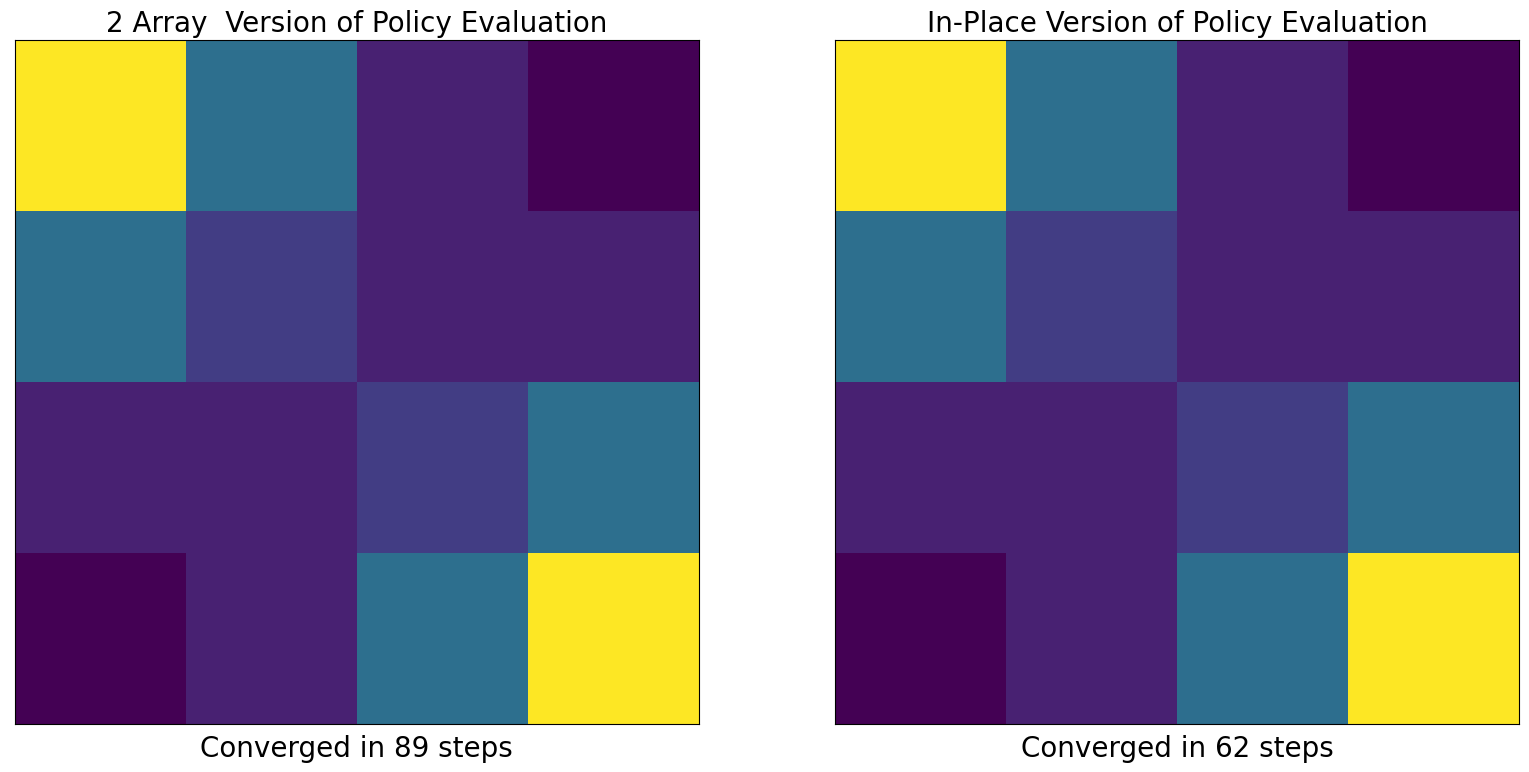

In [6]:
policyEval_2Array = world.evaluatePolicy_2Array(gamma = 1)
policyEval_InPlace = world.evaluatePolicy_InPlace(gamma = 1)

plt.figure(figsize=(30,10))

plt.subplot(131),plt.imshow(policyEval_2Array[0])
plt.title("2 Array  Version of Policy Evaluation", fontsize=20)
plt.xlabel("Converged in {} steps".format(policyEval_2Array[1]), fontsize=20)
plt.xticks([]),plt.yticks([])

plt.subplot(132),plt.imshow(policyEval_InPlace[0])
plt.title("In-Place Version of Policy Evaluation", fontsize=20)
plt.xlabel("Converged in {} steps".format(policyEval_InPlace[1]), fontsize=20)
plt.xticks([]),plt.yticks([])
plt.show()

## 2) Combined plot of both versions of policy evaluation with varying discount rates

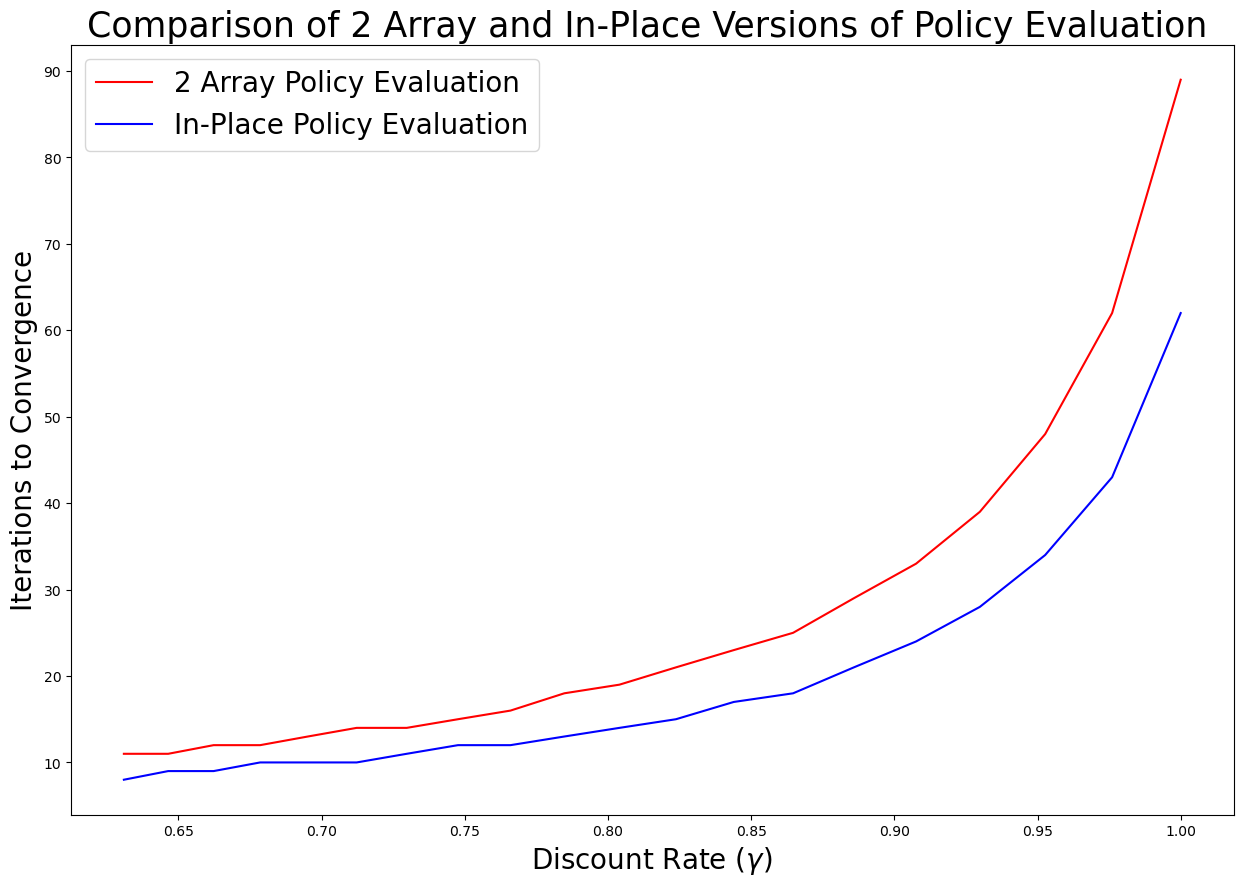

In [7]:
# Gammas to use
gammas = list(np.logspace(-0.2,0,num=20))


convergence_list_2Array = []
convergence_list_InPlace = []

# Loop for testing different gammas
for i in range(20):
    policyEval_2Array = world.evaluatePolicy_2Array(gamma = gammas[i])
    
    # Append convergence counts for 2 Array version of policy evaluation
    convergence_list_2Array.append(policyEval_2Array[1])
    
    policyEval_InPlace = world.evaluatePolicy_InPlace(gamma = gammas[i])
    
    # Append convergence counts for 2 Array version of policy evaluation
    convergence_list_InPlace.append(policyEval_InPlace[1])
    
plt.figure(figsize=(15, 10))
plt.plot(gammas, convergence_list_2Array, color='red', label='2 Array Policy Evaluation')
plt.plot(gammas, convergence_list_InPlace, color='blue', label='In-Place Policy Evaluation')
plt.title("Comparison of 2 Array and In-Place Versions of Policy Evaluation ", fontsize=25)
plt.xlabel(r'Discount Rate ($\gamma$)', fontsize=20)
plt.ylabel("Iterations to Convergence", fontsize=20)
plt.legend(fontsize=20)
plt.show()
